# License Plate Detection and Blurring
## Part of Aegis - Image Anonymization System

This notebook detects and blurs license plates in images to protect privacy and anonymize vehicle information.

In [1]:
# Install required packages
# !pip install opencv-python
# !pip install matplotlib
# !pip install numpy

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

## License Plate Detection Class

In [3]:
class LicensePlateRedactor:
    """Detects and redacts license plates in images"""
    
    def __init__(self, method='blur'):
        """
        Initialize the redactor
        
        Args:
            method: Redaction method - 'blur', 'pixelate', or 'black'
        """
        self.method = method
        # Load Haar Cascade for license plate detection
        self.plate_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_russian_plate_number.xml'
        )
        
    def detect_plates(self, image):
        """Detect license plates in the image"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect plates
        plates = self.plate_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(25, 25)
        )
        
        return plates
    
    def blur_region(self, image, x, y, w, h, strength=51):
        """Apply Gaussian blur to a region"""
        roi = image[y:y+h, x:x+w]
        if strength % 2 == 0:
            strength += 1
        blurred = cv2.GaussianBlur(roi, (strength, strength), 0)
        image[y:y+h, x:x+w] = blurred
        return image
    
    def pixelate_region(self, image, x, y, w, h, pixel_size=10):
        """Apply pixelation to a region"""
        roi = image[y:y+h, x:x+w]
        
        # Resize down and up to create pixelation effect
        small = cv2.resize(roi, (pixel_size, pixel_size), interpolation=cv2.INTER_LINEAR)
        pixelated = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)
        
        image[y:y+h, x:x+w] = pixelated
        return image
    
    def blackout_region(self, image, x, y, w, h):
        """Black out a region"""
        image[y:y+h, x:x+w] = 0
        return image
    
    def redact_plates(self, image, strength=51, show_detections=False):
        """
        Main function to detect and redact license plates
        
        Args:
            image: Input image
            strength: Blur strength or pixelation size
            show_detections: Whether to draw boxes around detections
        
        Returns:
            Processed image, number of plates detected
        """
        result = image.copy()
        plates = self.detect_plates(image)
        
        # Draw detection boxes if requested
        if show_detections:
            for (x, y, w, h) in plates:
                cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Apply redaction based on method
        for (x, y, w, h) in plates:
            if self.method == 'blur':
                result = self.blur_region(result, x, y, w, h, strength)
            elif self.method == 'pixelate':
                result = self.pixelate_region(result, x, y, w, h, strength)
            elif self.method == 'black':
                result = self.blackout_region(result, x, y, w, h)
        
        return result, len(plates)

## Utility Functions

In [4]:
def display_images(original, processed, num_plates):
    """Display original and processed images side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Convert BGR to RGB for display
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
    
    axes[0].imshow(original_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(processed_rgb)
    axes[1].set_title(f'Redacted Image ({num_plates} plate(s) detected)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

def process_single_image(image_path, output_path, method='blur', strength=51, show_detections=False):
    """Process a single image"""
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    # Create redactor and process
    redactor = LicensePlateRedactor(method=method)
    processed, num_plates = redactor.redact_plates(image, strength, show_detections)
    
    # Save result
    cv2.imwrite(output_path, processed)
    
    print(f"Detected and redacted {num_plates} license plate(s)")
    print(f"Saved to: {output_path}")
    
    return image, processed, num_plates

def process_directory(input_dir, output_dir, method='blur', strength=51):
    """Process all images in a directory"""
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Supported image extensions
    extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    
    # Process each image
    total_plates = 0
    processed_count = 0
    
    for file_path in Path(input_dir).iterdir():
        if file_path.suffix.lower() in extensions:
            try:
                output_path = Path(output_dir) / f"redacted_{file_path.name}"
                _, _, num_plates = process_single_image(
                    str(file_path),
                    str(output_path),
                    method=method,
                    strength=strength
                )
                total_plates += num_plates
                processed_count += 1
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    
    print(f"\nProcessed {processed_count} images")
    print(f"Total plates detected: {total_plates}")

## Example Usage - Single Image

Detected and redacted 2 license plate(s)
Saved to: C:\Users\Lenovo\Pictures\Saved Pictures\redacted_car_blur.jpg


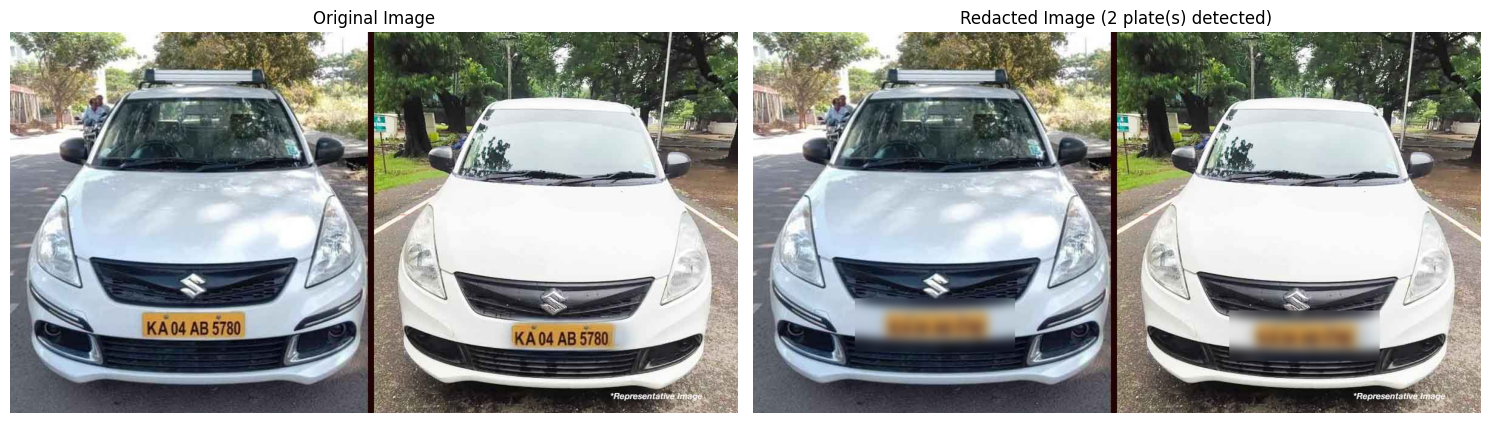

In [8]:
# Process a single image with blur method
input_image = "C:\\Users\\Lenovo\\Downloads\\2-maruti-dzire-with-same-number.jpg"  # Update with your image path
output_image = "C:\\Users\\Lenovo\\Pictures\\Saved Pictures\\redacted_car_blur.jpg"

try:
    original, processed, num_plates = process_single_image(
        input_image,
        output_image,
        method='blur',
        strength=51,
        show_detections=False
    )
    
    # Display results
    display_images(original, processed, num_plates)
    
except Exception as e:
    print(f"Error: {e}")

## Example Usage - Pixelation Method

Detected and redacted 2 license plate(s)
Saved to: C:\Users\Lenovo\Pictures\Saved Pictures\redacted_car_pixelated.jpg


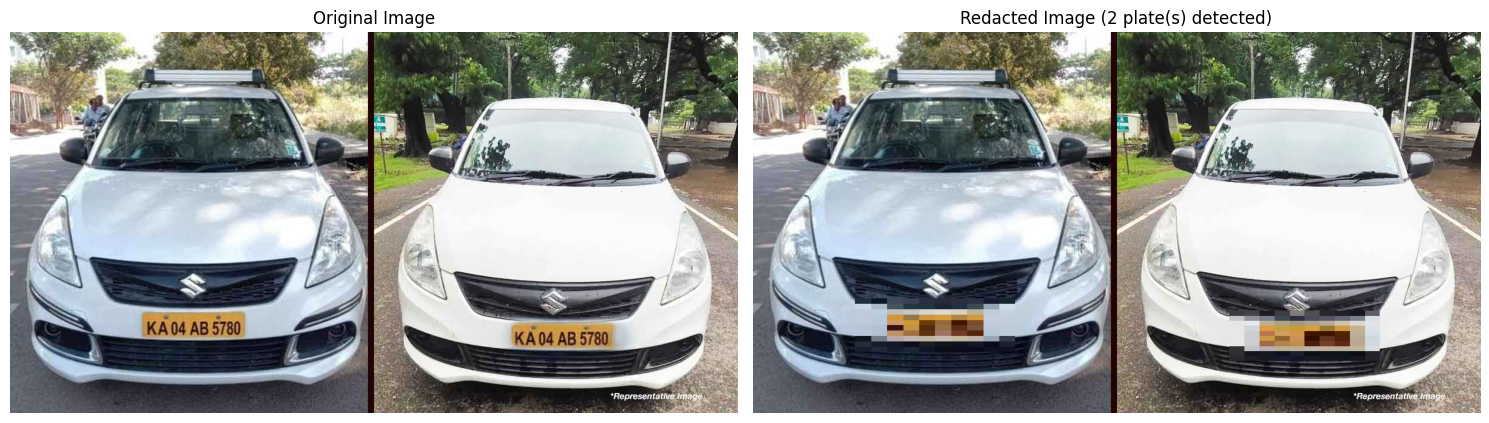

In [9]:
# Process with pixelation
output_pixelated = "C:\\Users\\Lenovo\\Pictures\\Saved Pictures\\redacted_car_pixelated.jpg"

try:
    original, processed, num_plates = process_single_image(
        input_image,
        output_pixelated,
        method='pixelate',
        strength=10,  # Pixel size
        show_detections=False
    )
    
    display_images(original, processed, num_plates)
    
except Exception as e:
    print(f"Error: {e}")

## Example Usage - Show Detection Boxes

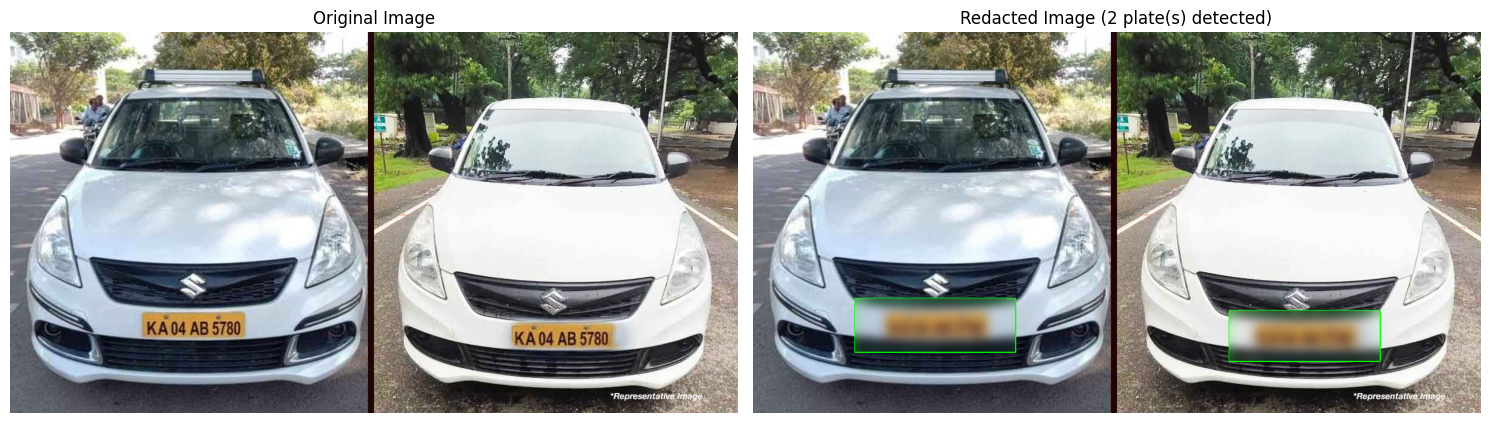

In [10]:
# Show detection boxes before blurring
image = cv2.imread(input_image)
redactor = LicensePlateRedactor(method='blur')
processed_with_boxes, num_plates = redactor.redact_plates(
    image,
    show_detections=True
)

display_images(image, processed_with_boxes, num_plates)

## Batch Processing - Process Multiple Images

In [ ]:
# Process all images in a directory
input_directory = "assets/input_images"
output_directory = "assets/output_images"

try:
    process_directory(
        input_directory,
        output_directory,
        method='blur',
        strength=51
    )
except Exception as e:
    print(f"Error: {e}")

## Integration with Other Aegis Modules

In [ ]:
def full_anonymization_pipeline(image_path, output_path):
    """
    Complete anonymization pipeline combining:
    - Face redaction (from redact_faces.ipynb)
    - Name redaction (from redact_names.ipynb)
    - License plate redaction (this module)
    """
    image = cv2.imread(image_path)
    
    # Step 1: Redact license plates
    plate_redactor = LicensePlateRedactor(method='blur')
    image, num_plates = plate_redactor.redact_plates(image, strength=51)
    print(f"Redacted {num_plates} license plate(s)")
    
    # Step 2: Add face redaction here (integrate from redact_faces.ipynb)
    # Step 3: Add name redaction here (integrate from redact_names.ipynb)
    
    # Save final result
    cv2.imwrite(output_path, image)
    print(f"Full anonymization complete. Saved to: {output_path}")
    
    return image

# Example usage
# full_anonymization_pipeline("input.jpg", "output_anonymized.jpg")